In [ ]:
    #| default_exp activations

## Activation stats

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export 
from __future__ import annotations
import random, math, torch, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [ ]:
import torch.nn.functional as F, matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

plt.style.use('dark_background')

In [ ]:
#| export
def set_seed(seed, determenistic=False):
    # make torch use deterministic algorithms when available
    torch.use_deterministic_algorithms(determenistic)
    # set seed for torch, random and numpy
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dsd.cache_files

{'train': [{'filename': '/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/fashion_mnist-train.arrow'}],
 'test': [{'filename': '/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/fashion_mnist-test.arrow'}]}

## Baseline

Let's define a baseline model to work with

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5), #14x14
        conv(8, 16),      #7x7
        conv(16, 32),     #4x4
        conv(32, 64),     #2x2
        conv(64, 10, act=False), #1x1
        nn.Flatten()]

We want to train quickly, so that means training at a high learning rate.

In [ ]:
from torcheval.metrics import MulticlassAccuracy

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [ ]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, 
                    lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.151,2.299,0,train
0.294,2.139,0,eval


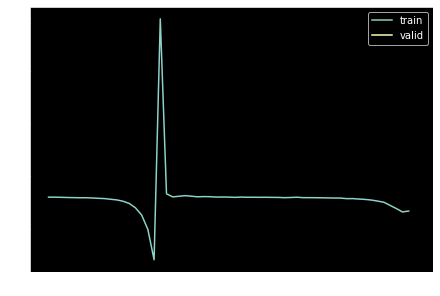

In [ ]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion 

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            # append means and stds of each layer to list
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    # make it an iterator to loop through layers
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.155,2.301,0,train
0.199,2.135,0,eval


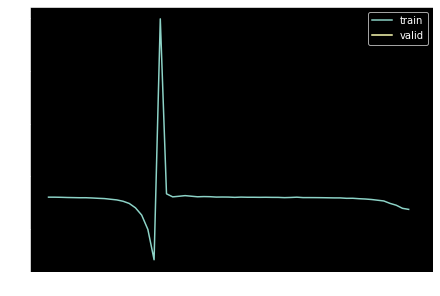

In [ ]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

Plot means and stds for every batch. We see that activations are increasing at an exponential rate and then drop to zero. This is vey bad news for us becaus it practically means that there is no training at all - inputs to each next layer are zero and outputs are zero. Generally we weant mean to be zero and standard deviation to be 1.

Here after batch 30 means are zero and stds are zero, which means all numbers are bascially the same and zero.

__Maybe add color graph (Karpathy)__

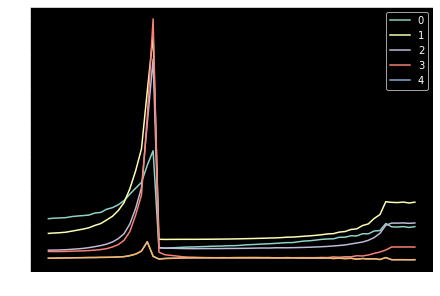

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

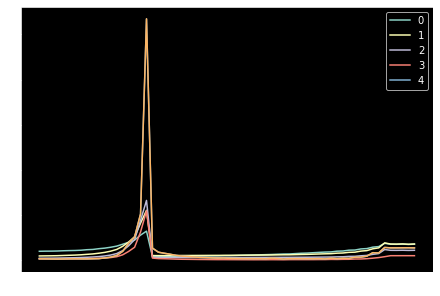

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Pytorch hooks 

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [ ]:
# to keep tracks means and stds for each layer
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [ ]:
def append_stats(i, # the layer number
                 mod, # the module
                 inp, # input
                 outp # output):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [ ]:
# we go through each layer of a model, grab its layer and pass `append_stats` funtion
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats,i))

accuracy,loss,epoch,train
0.151,2.299,0,train
0.294,2.140,0,eval


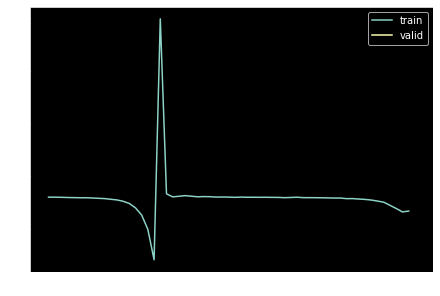

<miniai.learner.Learner>

In [ ]:
 fit(model)

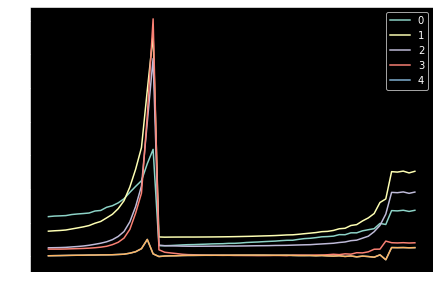

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

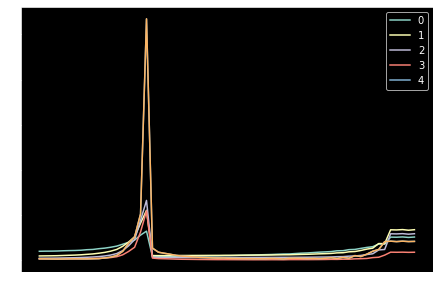

In [ ]:
for o in act_stds: plt.plot(o)
plt.legend(range(5));

## Hoook class 

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

From Pytroch: m.register_forward_hook

The hook will be called every time after `forward` has computed an output.
It should have the following signature:

    hook(module, input, output) -> None or modified output


In [ ]:
#| export
class Hook:
    def __init__(self, 
                 m, # module that we a hooking
                 f # function
                ):
        self.hook = m.register_forward_hook(partial(f, self))
    # remove hook
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
# we need to pass `hook` as additional argument to capture its reference
# and append to its stats attribute
def append_stats(hook, mod, inp, outp):
    # if not stats attribute - create it
    if not hasattr(hook, 'stats'): hook.stats = ([],[])
    # put stats to cpu and calculate stats
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We create a list of hooks, where each hook is for a model layer. During initialization it registers itself as a forward hook for that module and applies `append_stats` (`f`) to it.

In [ ]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

In [ ]:
hooks

[<__main__.Hook>,
 <__main__.Hook>,
 <__main__.Hook>,
 <__main__.Hook>,
 <__main__.Hook>]

accuracy,loss,epoch,train
0.151,2.299,0,train
0.297,2.140,0,eval


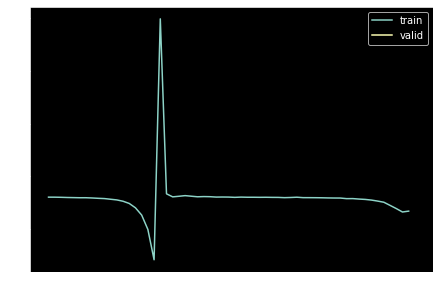

In [ ]:
learn = fit(model)

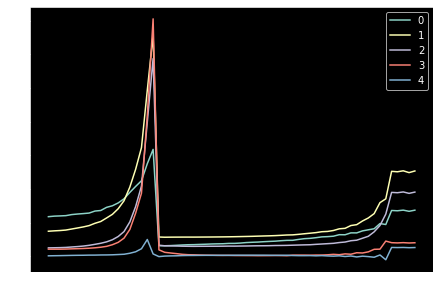

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

## A Hooks class

Let's go further and create a Hook**s** class. We will use contextmanager for it, so let's remind ourselves about it.

In [ ]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go")
        return self
    def __exit__(self, *args): print("all done!")
    def hello(self): print("hello.")

First `__enter__` method is run and it returns `self` and puts it into `dcm` variable.

In [ ]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go
hello.
all done!


We can also inherit from python standard library and extend functionaliy of the built-in objects

In [ ]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to {self[i]}")
        super().__delitem__(i)

In [ ]:
dml = DummyList([1,2,3])
dml

[1, 2, 3]

In [ ]:
del(dml[1])

Say bye to 2


To create a context manager we create a class with two special methods: `__enter__` and `__exit__`. `__enter__` is run as soon as we hit `with` statement and its result is stored into `as` variable.

In [ ]:
#| export
class Hooks(list):
    # register hooks for each module using class constructor
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.154,2.301,0,train
0.197,2.120,0,eval


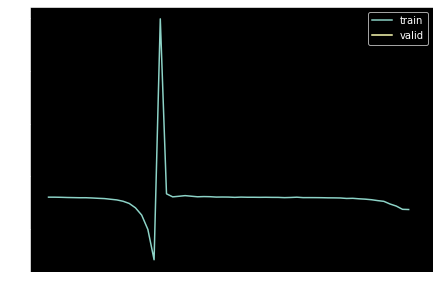

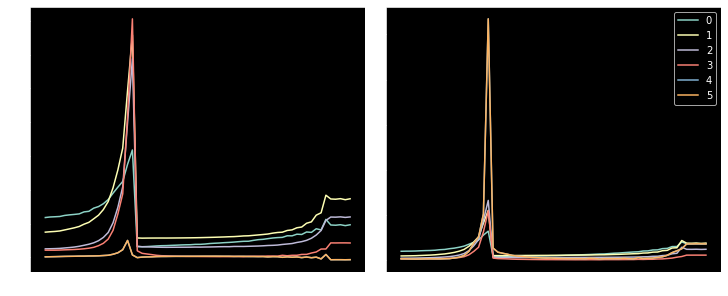

In [ ]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(5))

## HooksCallback

Due to some limitations with context manager, let's create HooksCallback

In [ ]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, 
                 on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    
    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
        
    
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
fc.filter_ex??

Signature:
fc.filter_ex(
    iterable,
    f=<function noop at 0x7f6439986ca0>,
    negate=False,
    gen=False,
    **kwargs,
)
Source:   
def filter_ex(iterable, f=noop, negate=False, gen=False, **kwargs):
    "Like `filter`, but passing `kwargs` to `f`, defaulting `f` to `noop`, and adding `negate` and `gen`"
    if f is None: f = lambda _: True
    if kwargs: f = partial(f,**kwargs)
    if negate: f = not_(f)
    res = filter(f, iterable)
    if gen: return res
    return list(res)
File:      /usr/local/lib/python3.9/dist-packages/fastcore/basics.py
Type:      function


In [ ]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.155,2.301,0,train
0.199,2.134,0,eval


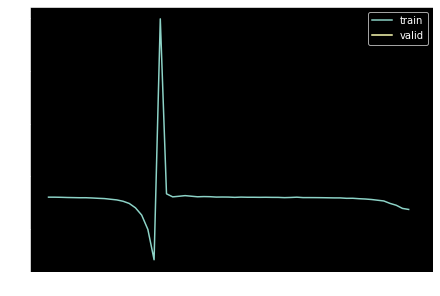

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

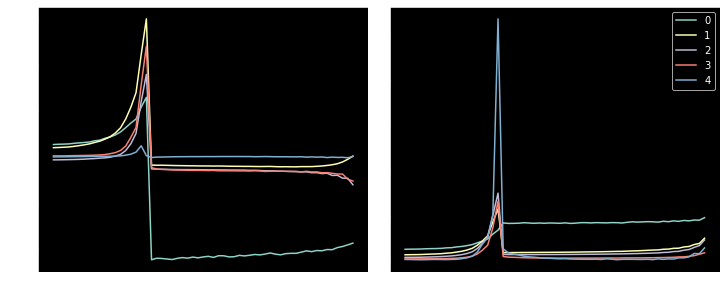

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(5));

## Histograms

In [ ]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    # add histogram of absolute values of activations
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.151,2.299,0,train
0.298,2.145,0,eval


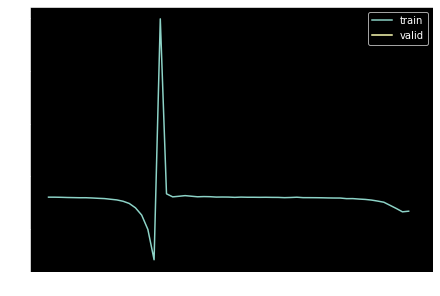

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [ ]:
test_hook = next(iter(hc))

In [ ]:
test_hook.stats[2][0:2]

[tensor([1212566.,  287863.,   66816.,   33731.,    4465.,     191.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.]),
 tensor([1207453.,  290291.,   66984.,   35503.,    5185.,     216.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.,       0.])]

In [ ]:
get_hist(test_hook)

tensor([[14.01, 14.00, 14.00,  ..., 13.61, 13.62, 13.09],
        [12.57, 12.58, 12.59,  ..., 12.70, 12.67, 12.16],
        [11.11, 11.11, 11.10,  ..., 11.43, 11.38, 10.89],
        ...,
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00]])

In [ ]:
torch.stack(test_hook.stats[2][0:2]).t().float().log1p()

tensor([[14.01, 14.00],
        [12.57, 12.58],
        [11.11, 11.11],
        [10.43, 10.48],
        [ 8.40,  8.55],
        [ 5.26,  5.38],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00],
        [ 0.00,  0.00]])

In [ ]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

The colorful dimesnion graphs shows a histogram for each pixel column. It takes a histogram for each batch are unrolls it onto a single coloumn, where y-axis is a histogram bins, x-axis is batches and color represents how many values there are for every bin.

Ideally we would like to see a rectangle with a maximum not changing very much. Even gradient - each column should have a normal distribution. Here we see that the majority of values are around zero.

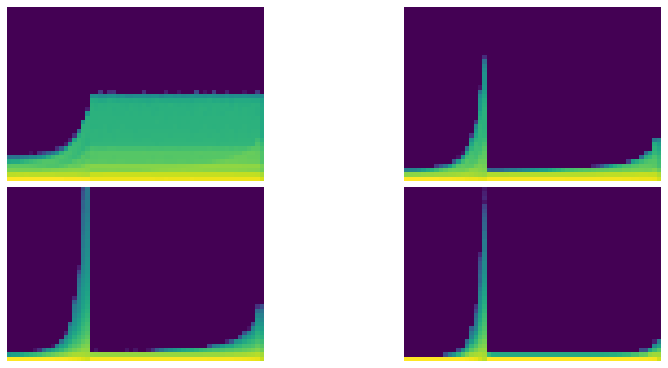

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [ ]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    # take ratio of two lowest bins (near zero) and check their ratio to the rest acivations
    return h1[:2].sum(0) / h1.sum(0)

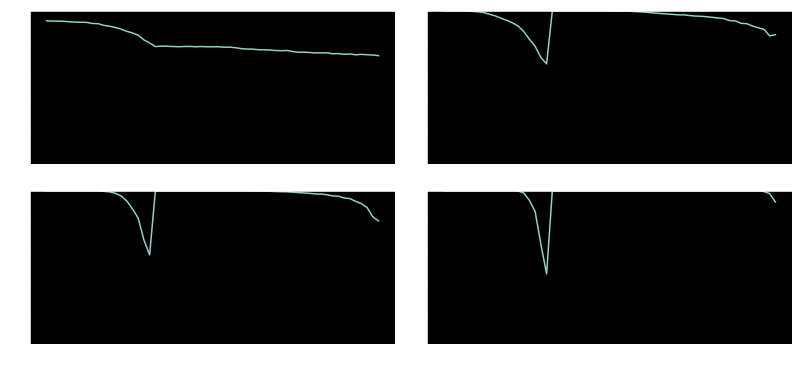

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats 

In [ ]:
#| export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)
    
    
    def color_dim(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
      
    
    def dead_chart(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)
    
    
    def plot_stats(self, figsize=(10,4)):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0,1: axes[i].plot(h.stats[i])
        axes[0].set_title('Means')
        axes[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.153,2.301,0,train
0.190,2.148,0,eval


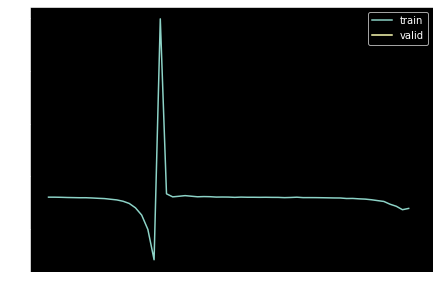

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

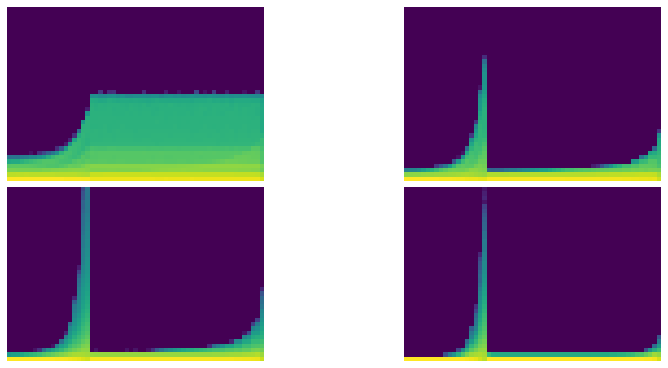

In [ ]:
astats.color_dim()

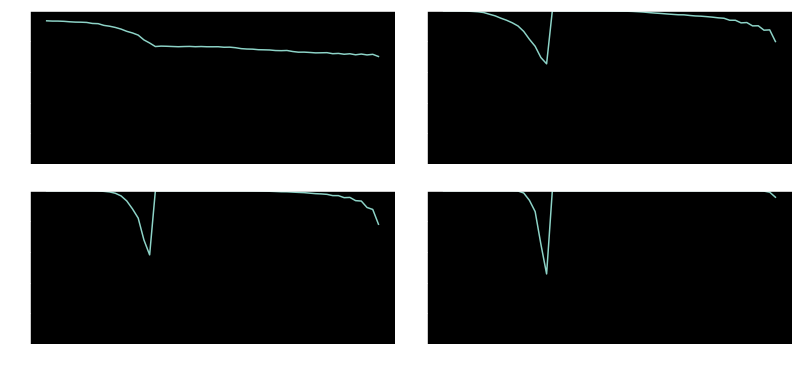

In [ ]:
astats.dead_chart()

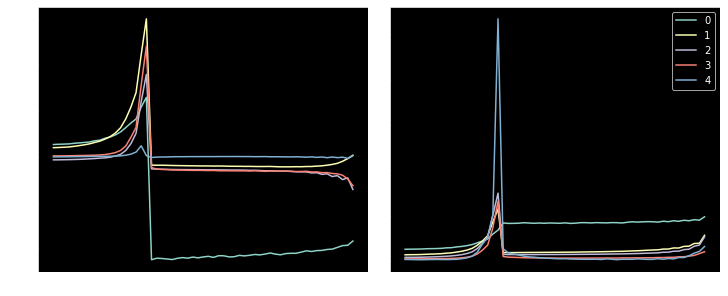

In [ ]:
astats.plot_stats()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()